<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dill, os, uproot

In [2]:
# Load real data
file = uproot.open("../Data/data15_13TeV.00267358.physics_MinBias.30062015_v0_per_0.root")
T = file['tree']
df = T.pandas.df("v0_rxy v0_chi2 cosTheta v0_ks_mass".split(" "), entrystop = 1e5)


In [3]:
# Find outliers rought. Through five sigma away
z = (df - df.mean()) / df.std()
throw = z > 5
keep = throw.sum(axis = 1).apply(lambda x: x == 0)

df = df.loc[keep, :].reset_index(drop = True)


In [4]:
cutter_binary = dill.load(open("models/cutter_80_significance.dat", 'rb'))
cutter = dill.loads(cutter_binary)

In [5]:
label = pd.Series(cutter(df), dtype = bool)

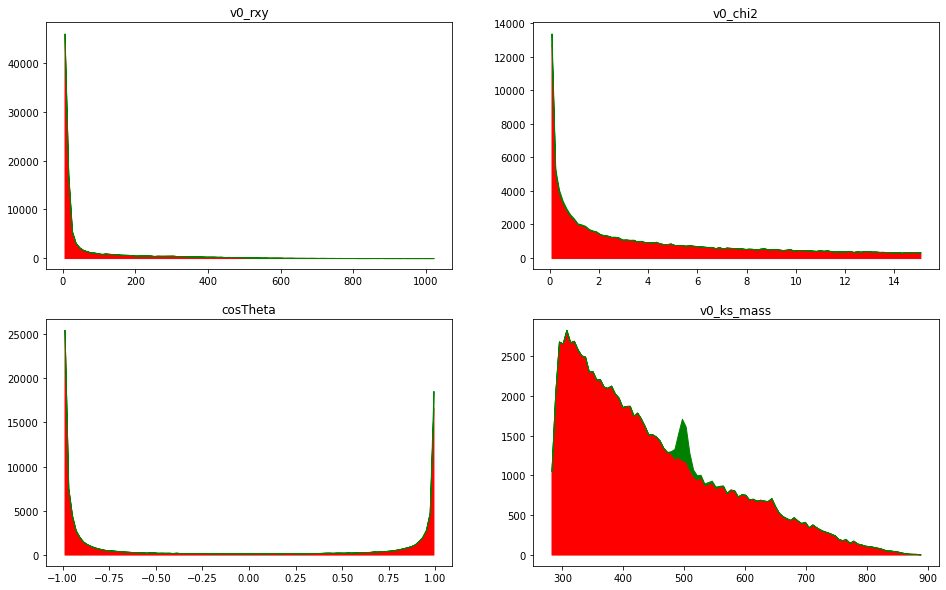

In [6]:
bins = 100

fig, ax = plt.subplots(figsize = (16, 10), ncols = 2, nrows = 2)
ax = ax.flatten()

for i, col in enumerate(df.columns):
    
    limits = (df[col].min(), df[col].max()) 
    
    true, false = df.loc[label, col], df.loc[label.apply(lambda x: not x), col]
    
    val_t, bins_t = np.histogram(true, bins = bins, range = limits)
    val_f, bins_f = np.histogram(false, bins = bins, range = limits)
    
    bins_t = 1/2*(bins_t[1:] + bins_t[:-1])
    bins_f = 1/2*(bins_f[1:] + bins_f[:-1])
    
    
    ax[i].set_title(col)
    
    ax[i].fill_between(bins_f, val_f, color = 'red')
    ax[i].fill_between(bins_t, val_t + val_f, val_f, color = 'green')

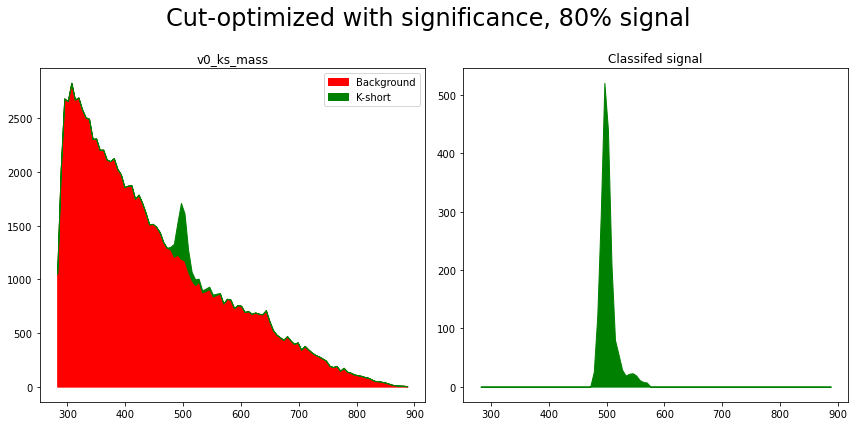

In [7]:
fig, ax = plt.subplots(ncols = 2, figsize = (12, 6))

ks_mass = df.v0_ks_mass

limits = (df[col].min(), df[col].max()) 
    
true, false = ks_mass[label], ks_mass[label.apply(lambda x: not x)]

val_t, bins_t = np.histogram(true, bins = bins, range = limits)
val_f, bins_f = np.histogram(false, bins = bins, range = limits)

bins_t = 1/2*(bins_t[1:] + bins_t[:-1])
bins_f = 1/2*(bins_f[1:] + bins_f[:-1])

fig.suptitle("Cut-optimized with significance, 80% signal", fontsize = 24)

ax[0].set_title('v0_ks_mass')

ax[0].fill_between(bins_f, val_f, color = 'red', label = "Background")
ax[0].fill_between(bins_t, val_t + val_f, val_f, color = 'green', label = "K-short")


ax[1].set_title("Classifed signal")
ax[1].fill_between(bins_t, val_t, color = "green")

ax[0].legend(loc = "upper right")

fig.tight_layout(rect = (0, 0, 1, 0.9))


In [8]:
# Trying with the lightgbm 
df_all = T.pandas.df(entrystop = 5e4)

# Find outliers rought. Throw five sigma away
z = (df_all - df_all.mean()) / df_all.std()
throw = z > 3
keep = throw.sum(axis = 1).apply(lambda x: x == 0)

df_all = df_all.loc[keep, :].reset_index(drop = True)



cutter_binary = dill.load(open("models/MC_trained_lightgbm_top15features.dat", 'rb'))
cutter = dill.loads(cutter_binary)

In [9]:
label = pd.Series(cutter(df_all.iloc[:, :57]), dtype = bool)

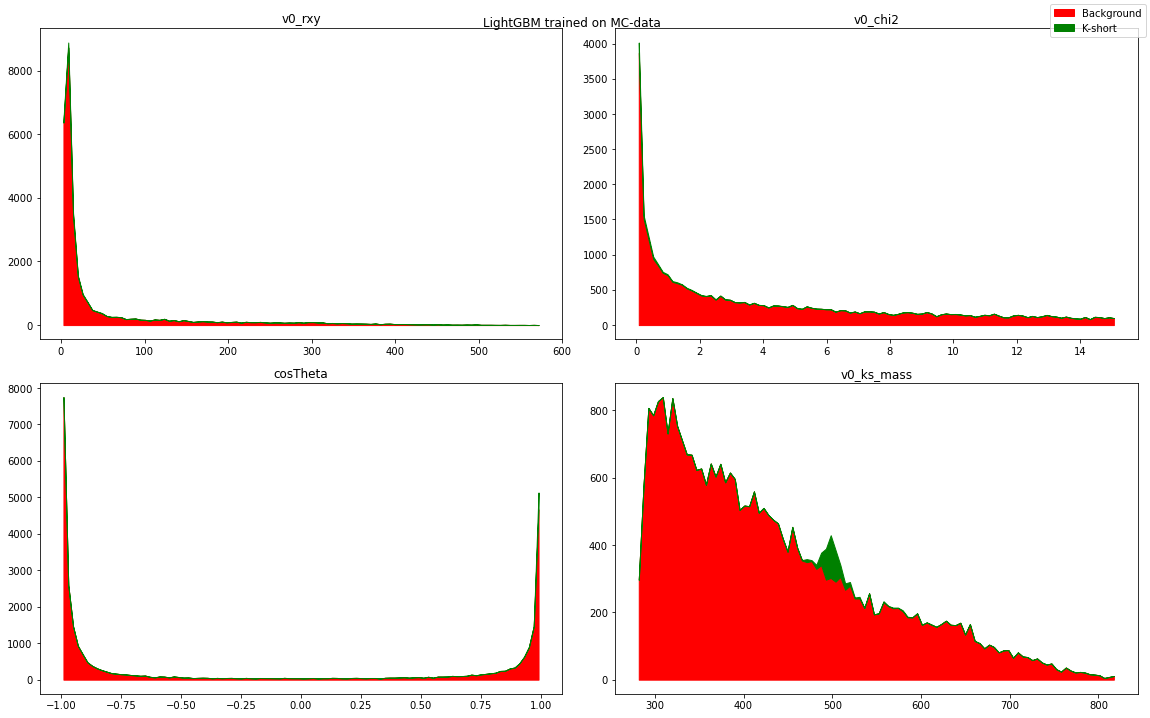

In [10]:
bins = 100

fig, ax = plt.subplots(figsize = (16, 10), ncols = 2, nrows = 2)
ax = ax.flatten()

for i, col in enumerate(df.columns):
    
    limits = (df_all[col].min(), df_all[col].max()) 
    
    true, false = df_all.loc[label, col], df_all.loc[label.apply(lambda x: not x), col]
    
    val_t, bins_t = np.histogram(true, bins = bins, range = limits)
    val_f, bins_f = np.histogram(false, bins = bins, range = limits)
    
    bins_t = 1/2*(bins_t[1:] + bins_t[:-1])
    bins_f = 1/2*(bins_f[1:] + bins_f[:-1])
    
    fig.suptitle("LightGBM trained on MC-data")
    
    ax[i].set_title(col)
    
    if i == 0:
        ax[i].fill_between(bins_f, val_f, color = 'red', label = "Background")
        ax[i].fill_between(bins_t, val_t + val_f, val_f, color = 'green', label = "K-short")
    else:
        ax[i].fill_between(bins_f, val_f, color = 'red')
        ax[i].fill_between(bins_t, val_t + val_f, val_f, color = 'green')

fig.legend(loc = 'upper right')    

fig.tight_layout()

In [14]:
ks_mass = df_all.v0_ks_mass
# ks_mass = df.v0_ks_mass

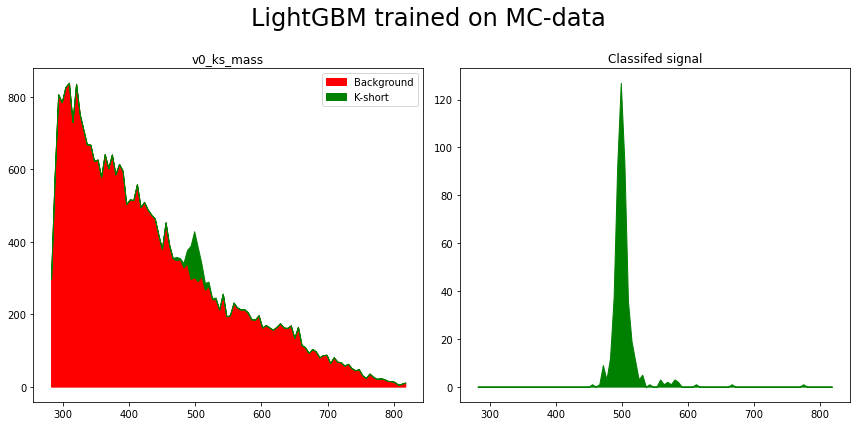

In [15]:
fig, ax = plt.subplots(ncols = 2, figsize = (12, 6))

limits = (df_all[col].min(), df_all[col].max()) 
    
true, false = ks_mass[label], ks_mass[label.apply(lambda x: not x)]

val_t, bins_t = np.histogram(true, bins = bins, range = limits)
val_f, bins_f = np.histogram(false, bins = bins, range = limits)

bins_t = 1/2*(bins_t[1:] + bins_t[:-1])
bins_f = 1/2*(bins_f[1:] + bins_f[:-1])

fig.suptitle("LightGBM trained on MC-data", fontsize = 24)

ax[0].set_title('v0_ks_mass')

ax[0].fill_between(bins_f, val_f, color = 'red', label = "Background")
ax[0].fill_between(bins_t, val_t + val_f, val_f, color = 'green', label = "K-short")


ax[1].set_title("Classifed signal")
ax[1].fill_between(bins_t, val_t, color = "green")

ax[0].legend(loc = "upper right")

fig.tight_layout(rect = (0, 0, 1, 0.9))


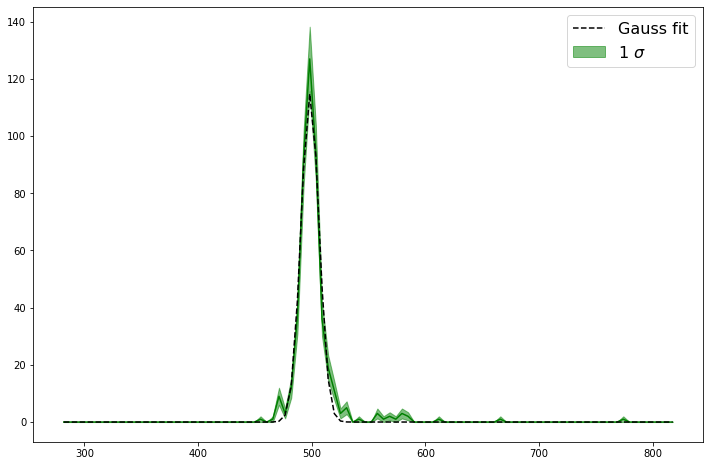

In [16]:
# lets try to fit the signal and background. We expect signal to be gaussian distributed, so lets try
# that with a chi2 fit
from iminuit import Minuit
from ExternalFunctions import Chi2Regression

fig_sig, ax_sig = plt.subplots(figsize = (12, 8))

errs = np.sqrt(val_t)

ax_sig.plot(bins_t, val_t, 'g-')
ax_sig.fill_between(bins_t, val_t + errs, val_t - errs, color = 'g', alpha = 0.5, label = '1 $\sigma$')

mask = val_t > 0


from scipy.stats import norm
from scipy.optimize import curve_fit

def fitfunc(x, N, mu, sigma):
    return N * norm.pdf(x, mu, sigma)

N, mu, sigma = curve_fit(fitfunc, bins_t[mask], val_t[mask], p0 = [1e5, 500, 10])[0]

chi2_obj = Chi2Regression(fitfunc, bins_t[mask], val_t[mask], errs[mask])
chi2_min = Minuit(chi2_obj, pedantic = False, mu = mu, N = N, sigma = sigma)
chi2_min.migrad()

ax_sig.plot(bins_t, fitfunc(bins_t, *chi2_min.args), 'k--', label = "Gauss fit")

# def fitfunc_2_norms(x, N, f, mu, sigma_1, sigma_2):
#     return fitfunc(x, N * f, mu, sigma_1) + fitfunc(x, (1 - f) * N, mu, sigma_2)

# N, f, mu, sigma_1, sigma_2 = curve_fit(fitfunc_2_norms, bins_t[mask], val_t[mask], p0 = [1e5, 0.75, 500, 10, 25])[0]

# chi2_obj = Chi2Regression(fitfunc_2_norms, bins_t[mask], val_t[mask], errs[mask])
# chi2_min = Minuit(chi2_obj, pedantic = False, mu = mu, N = N, sigma_1 = sigma_1, f = f, sigma_2 = sigma_2)
# chi2_min.migrad()

# ax_sig.plot(bins_t, fitfunc_2_norms(bins_t, *chi2_min.args), '--', label = "2 Gauss fit", color = "orange")

ax_sig.legend(loc = 'upper right', prop = {'size': 16})